In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from train.models.decoder_seq import DecoderSeq
from train.models.seq2seq import Seq2seq
from util.common import get_encoder, compute_saliency_maps
import torch

from train.models.encoder_resnet import EncoderResnet

model_path = 'resnet-seq2seq-model.pt'

hidden_dim = 256
embed_dim = 128
output_dim = 41100
num_layers = 1
encoder = get_encoder('resnet', hidden_dim)
decoder = DecoderSeq(output_dim, embed_dim, hidden_dim, num_layers)
device = 'cpu'
model = Seq2seq(encoder, decoder, device)
#model = EncoderResnet(512)
print(model.load_state_dict(torch.load(model_path, map_location='cpu')))

model = model.encoder

/Users/kim-seung-gyeom/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kim-seung-gyeom/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>


In [11]:
from torch.utils.data import DataLoader
import dataset as d
import pandas as pd
test_data = pd.read_csv('./data/open/test_data.csv')
test_transform = d.ImageTransForm(224)
test_dataset = d.CustomDataset(test_data, 'test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32)
print()

In [6]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

device = torch.device('cpu')

predcit = []
mos_y = []
a = 0
model.eval()
with torch.no_grad():
    for img, mos, comment in test_loader:
        x = img.to(device)
        y = mos.to(device)
        if type(model).__name__ == 'EncoderGoogleNet':
           mos_pred = model(x)
        else:
           out, mos_pred = model(x)

        predcit += mos_pred.reshape(-1).tolist()
        mos_y += y.tolist()
        a += 1
        if a== 1:
            break

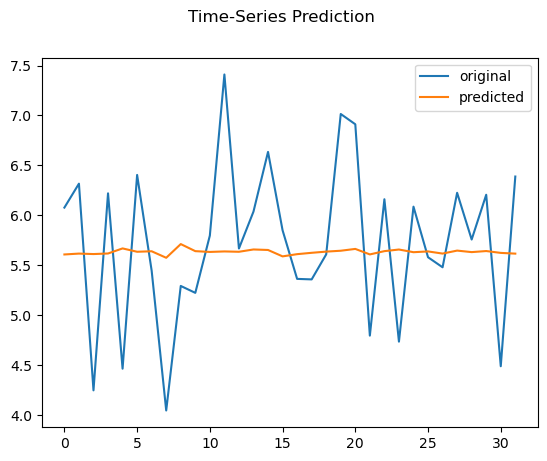

In [8]:
import matplotlib.pyplot as plt

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(mos_y, label='original')
plt.plot(predcit,label='predicted' )
plt.suptitle('Time-Series Prediction')
plt.legend(loc='best')
#plt.show()
plt.savefig('reset.png')

In [45]:
test_dataset = d.CustomDataset(test_data, 'test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)

torch.Size([5, 224, 224])


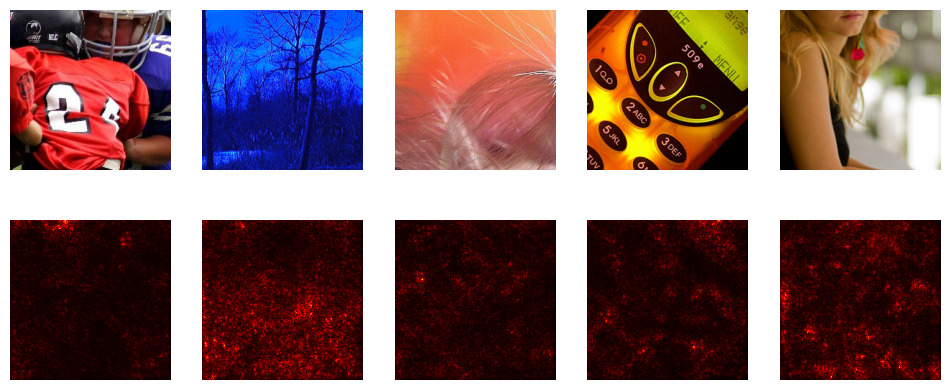

In [47]:
for img, mos, comment in test_loader:
    mos =mos.reshape(-1 ,1)

    saliency = compute_saliency_maps(img, mos, model)
    saliency = saliency.numpy()
    N = img.shape[0]
    img =  img.detach()


    for i in range(N):
       plt.subplot(2, N, i + 1)
       plt.imshow(img[i].permute(1,2,0))
       plt.axis('off')
       plt.subplot(2, N, N + i + 1)
       plt.imshow(saliency[i], cmap=plt.cm.hot)
       plt.axis('off')
       plt.gcf().set_size_inches(12, 5)

    break